# Minimal TTT Plot Notebook
This notebook loads pickled results and produces a Time-to-Target (TTT) plot (empirical CDF of time-to-hit-target) per solver.

In [1]:
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def ecdf_success(times: np.ndarray):
    x = np.sort(times)
    if len(x) == 0:
        return x, np.array([])
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

def safe_get(d: dict, *keys, default=None):
    cur = d
    for k in keys:
        if cur is None:
            return default
        if isinstance(cur, dict):
            cur = cur.get(k, default)
        else:
            if hasattr(cur, k):
                cur = getattr(cur, k)
            else:
                return default
    return cur


In [2]:
from aux import safe_get

PICKLE_DIR = Path("pickles/tttplots")   # adjust if needed
GLOB = "gen*_instance*.pkl"              # adjust if needed

files = sorted(PICKLE_DIR.glob(GLOB))
if not files:
    files = sorted(PICKLE_DIR.rglob("*.pkl"))
print(f"Found {len(files)} pickle(s). Example:", files[:3])

rows = []
for p in files:
    with open(p, "rb") as f:
        data = pickle.load(f)
    if not isinstance(data, dict):
        continue
    for solver, sdata in data.items():
        time_to_target = (safe_get(sdata, "time_to_target") or
                          safe_get(sdata, "time"))
        hit = (safe_get(sdata, "hit") or safe_get(sdata, "success"))
        budget = (safe_get(sdata, "budget") or safe_get(sdata, "cutoff") or None)
        rows.append({
            "solver": str(solver).replace("ScQbf", ""),
            "instance": p.stem,
            "time_to_target": time_to_target,
            "hit": hit,
            "budget": budget,
        })

df = pd.DataFrame(rows)

# Minimal cleanup: numeric conversion and default hit inference when missing
df["time_to_target"] = pd.to_numeric(df["time_to_target"], errors="coerce")
if "hit" not in df or df["hit"].isna().all():
    df["hit"] = df["time_to_target"].notna().astype(int)

# Infer a per-(solver,instance) budget if none provided
if "budget" not in df or df["budget"].isna().all():
    df["budget"] = df.groupby(["solver","instance"])['time_to_target'].transform(
        lambda s: np.nanmax(s.values)
    )

print(df.shape)
df.head(8)


Found 15 pickle(s). Example: [PosixPath('pickles/tttplots/gen1_instance1.pkl'), PosixPath('pickles/tttplots/gen1_instance2.pkl'), PosixPath('pickles/tttplots/gen1_instance3.pkl')]
(45, 5)


,solver,instance,time_to_target,hit,budget
0,Grasp,gen1_instance1,7.515203,1,7.515203
1,TS,gen1_instance1,5.035602,1,5.035602
2,GA,gen1_instance1,5.065199,1,5.065199
3,Grasp,gen1_instance2,7.022870,1,7.022870
4,TS,gen1_instance2,5.032974,1,5.032974
5,GA,gen1_instance2,5.056707,1,5.056707
6,Grasp,gen1_instance3,5.011404,1,5.011404
7,TS,gen1_instance3,5.000674,1,5.000674


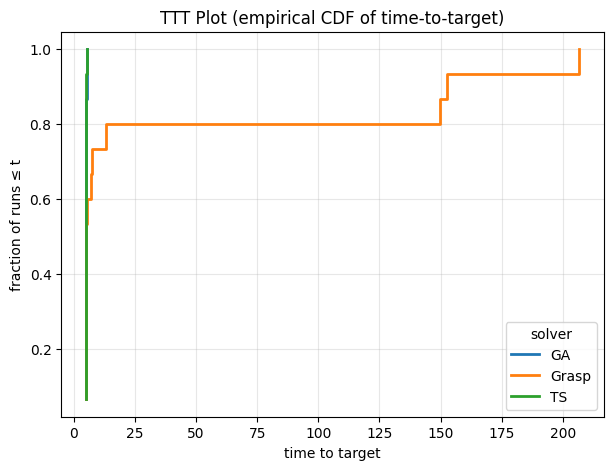

In [3]:
from aux import ecdf_success

plt.figure(figsize=(7, 5))
legend = []
for solver, d in df.groupby("solver"):
    succ = d.loc[d["hit"] == 1, "time_to_target"].dropna().to_numpy()
    if len(succ) == 0:
        continue
    xs, ys = ecdf_success(succ)
    plt.step(xs, ys, where="post", linewidth=2)
    legend.append(solver)

plt.xlabel("time to target")
plt.ylabel("fraction of runs ≤ t")
plt.title("TTT Plot (empirical CDF of time-to-target)")
plt.grid(True, alpha=0.3)
if legend:
    plt.legend(legend, title="solver")
plt.show()
